In [31]:
import yfinance as yf
from matplotlib import pyplot as plt
import numpy as np
#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import random
import pandas as pd

def get_prices(share_symbol, start_date, end_date, force=False):
    stock_hist = yf.download(share_symbol, start=start_date, end=end_date)
        #stock_hist = share.get_historical(start_date, end_date)
    stock_prices = []
    stock_hist = stock_hist.sort_values(by=['Date'])
    for index, day in stock_hist.iterrows():
        stock_val = day['Open'].astype(float)
        stock_prices.append(stock_val)
        
    stock_prices = np.asarray(stock_prices)
    return stock_prices


In [32]:
def plot_prices(prices):
    plt.title('Opening stock prices')
    plt.xlabel('day')
    plt.ylabel('price ($)')
    plt.plot(prices)
    plt.show()

[*********************100%%**********************]  1 of 1 completed

[2.24218798 2.17968798 2.22265601 2.27343798 2.296875   2.328125
 2.296875   2.296875   2.27343798 2.3125    ]


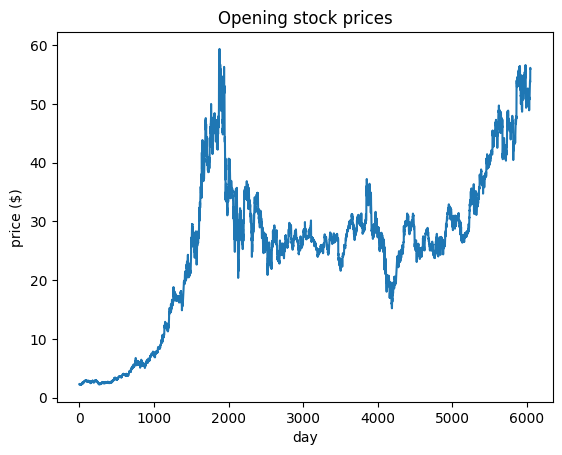

In [40]:
prices = get_prices('MSFT', '1992-07-22', '2016-07-22', force=True)
print(prices[:10])
plot_prices(prices)

In [34]:
class DecisionPolicy:
    '''
    Given a state, the decision policy will calculate the next action to take.
    '''
    def select_action(self, current_state, step):
        pass

    '''
    Improve the Q-function from a new experience of taking an action.
    '''
    def update_q(self, state, action, reward, next_state):
        pass

In [35]:
class RandomDecisionPolicy(DecisionPolicy):
    def __init__(self, actions):
        self.actions = actions
    def select_action(self, current_state, step):
        action = random.choice(self.actions)
        return action

In [36]:
class QLearningDecisionPolicy(DecisionPolicy):
    def __init__(self, actions, input_dim):
        self.epsilon = 0.95
        self.gamma = 0.3
        self.actions = actions
        output_dim = len(actions)
        h1_dim = 20

        self.x = tf.placeholder(tf.float32, [None, input_dim])
        self.y = tf.placeholder(tf.float32, [output_dim])
        W1 = tf.Variable(tf.random_normal([input_dim, h1_dim]))
        b1 = tf.Variable(tf.constant(0.1, shape=[h1_dim]))
        self.h1 = tf.nn.relu(tf.matmul(self.x, W1) + b1)
        W2 = tf.Variable(tf.random_normal([h1_dim, output_dim]))
        b2 = tf.Variable(tf.constant(0.1, shape=[output_dim]))
        self.q = tf.nn.relu(tf.matmul(self.h1, W2) + b2)
       
        loss = tf.square(self.y - self.q)
        self.train_op = tf.train.AdagradOptimizer(0.01).minimize(loss)
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        
    def select_action(self, current_state, step):
        threshold = min(self.epsilon, step / 1000.)
        if random.random() < threshold:
            action_q_vals = self.sess.run(self.q, feed_dict={self.x:current_state})
            #print(np.shape(action_q_vals))
            #print(self.sess.run(tf.shape(self.h1),feed_dict={self.x:current_state}))
            #print(self.sess.run(tf.shape(self.x), feed_dict={self.x:current_state}))
            #print(current_state)
            action_idx = np.argmax(action_q_vals)
            action = self.actions[action_idx]
        else:
            action = self.actions[random.randint(0, len(self.actions) - 1)]
        return action

    def update_q(self, state, action, reward, next_state):
        action_q_vals = self.sess.run(self.q, feed_dict={self.x: state})
        next_action_q_vals = self.sess.run(self.q, feed_dict={self.x:next_state})
        next_action_idx = np.argmax(next_action_q_vals)
        current_action_idx = self.actions.index(action)
        action_q_vals[0, current_action_idx] = reward + self.gamma * next_action_q_vals[0, next_action_idx]
        action_q_vals = np.squeeze(np.asarray(action_q_vals))
        self.sess.run(self.train_op, feed_dict={self.x: state, self.y:action_q_vals})

In [37]:
def run_simulation(policy, initial_budget, initial_num_stocks, prices, hist):
    budget = initial_budget # The state is a hist + 2 dimensional vector. You’ll force it to be a NumPy matrix.
    # Calculates the portfolio value
    num_stocks = initial_num_stocks
    share_value = 0
    transitions = list()
    for i in range(len(prices) - hist - 1):
        # Initializes values that depend on computing the net worth of a portfolio
        if i % 1000 == 0:
            print('progress {:.2f}%'.format(float(100*i) / (len(prices) - hist - 1)))
        current_state = np.asmatrix(np.hstack((prices[i:i+hist], budget, num_stocks)))
        current_portfolio = budget + num_stocks * share_value
        action = policy.select_action(current_state, i)
        share_value = float(prices[i + hist])
        
        if action == 'Buy' and budget >= share_value:
            budget -= share_value
            num_stocks += 1
        elif action == 'Sell' and num_stocks > 0:
            budget += share_value
            num_stocks -= 1
        else:
            action = 'Hold'

        # Updates portfolio values based on action
        new_portfolio = budget + num_stocks * share_value
        reward = new_portfolio - current_portfolio
        next_state = np.asmatrix(np.hstack((prices[i+1:i+hist+1], budget, num_stocks)))
        transitions.append((current_state, action, reward, next_state))

        policy.update_q(current_state, action, reward, next_state)
    
    #print(transitions)
    portfolio = budget + num_stocks * share_value
    return portfolio

In [38]:
def run_simulations(policy, budget, num_stocks, prices, hist):
# Updates the policy after experiencing a new action
 
    num_tries = 20
    final_portfolios = list()
    for i in range(num_tries):
        # Stores the portfolio worth of each run in this array
        # Runs this simulation
        final_portfolio = run_simulation(policy, budget, num_stocks, prices, hist)
        final_portfolios.append(final_portfolio)
        print('Final portfolio: ${}'.format(final_portfolio))
        plt.title('Final Portfolio Value')
        plt.xlabel('Simulation #')
        plt.ylabel('Net worth')
        plt.plot(final_portfolios)
        plt.show()

progress 0.00%
progress 16.55%
progress 33.10%
progress 49.65%
progress 66.20%
progress 82.75%
progress 99.30%
Final portfolio: $99990.28436684608


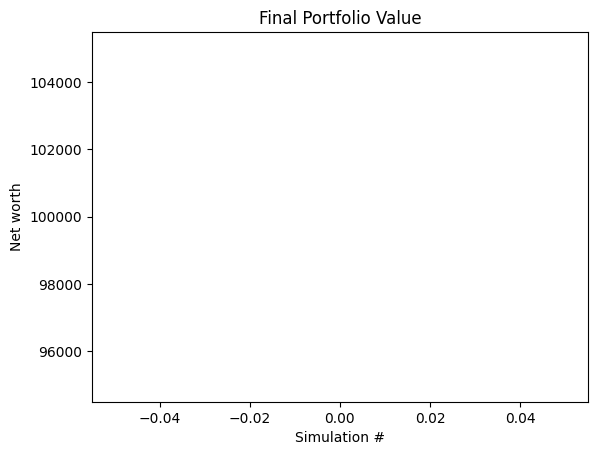

progress 0.00%
progress 16.55%
progress 33.10%
progress 49.65%
progress 66.20%
progress 82.75%
progress 99.30%
Final portfolio: $177149.09815859795


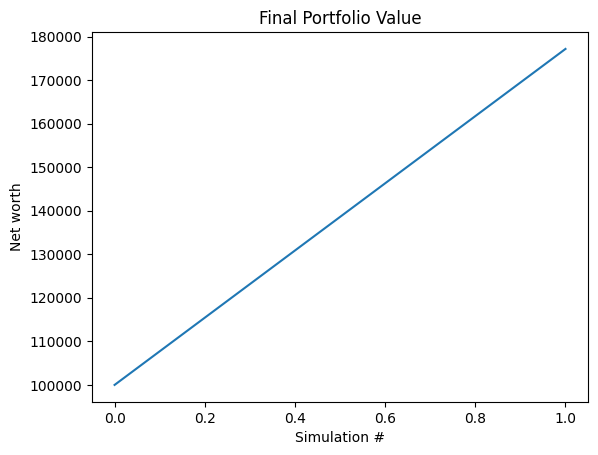

progress 0.00%
progress 16.55%
progress 33.10%
progress 49.65%
progress 66.20%
progress 82.75%
progress 99.30%
Final portfolio: $217193.88131308556


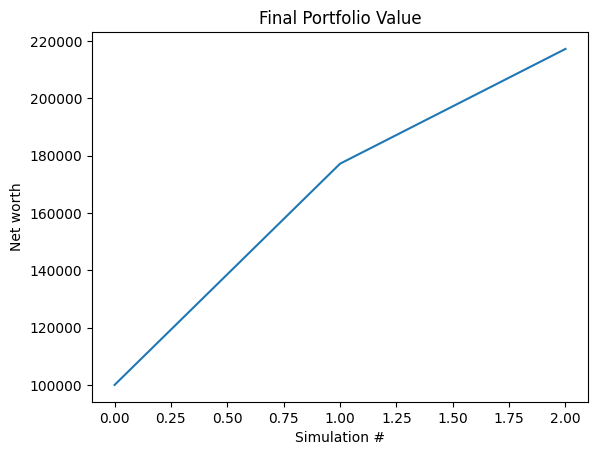

progress 0.00%
progress 16.55%
progress 33.10%
progress 49.65%
progress 66.20%
progress 82.75%
progress 99.30%
Final portfolio: $227030.97433543205


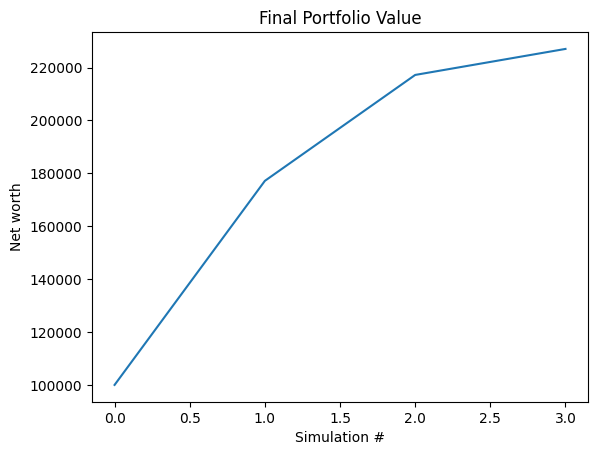

progress 0.00%
progress 16.55%
progress 33.10%
progress 49.65%
progress 66.20%
progress 82.75%
progress 99.30%
Final portfolio: $227604.17811393738


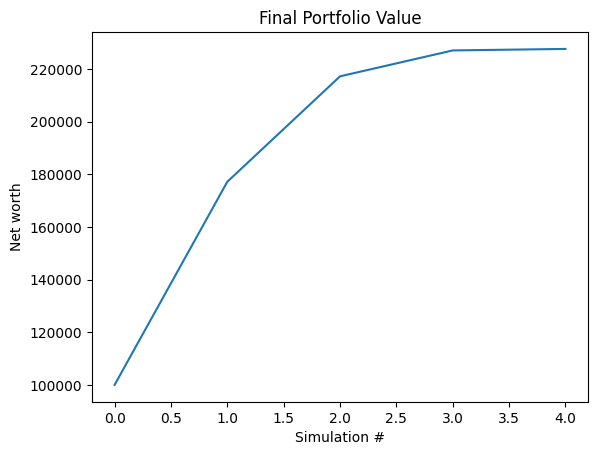

progress 0.00%
progress 16.55%
progress 33.10%
progress 49.65%
progress 66.20%
progress 82.75%
progress 99.30%
Final portfolio: $227094.63646650314


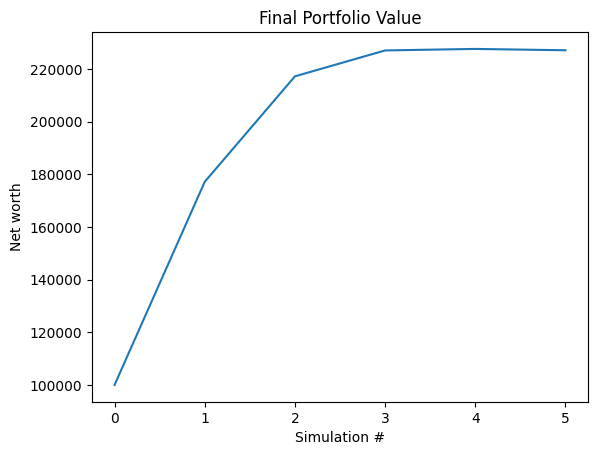

progress 0.00%
progress 16.55%
progress 33.10%
progress 49.65%
progress 66.20%
progress 82.75%
progress 99.30%
Final portfolio: $227665.53998064995


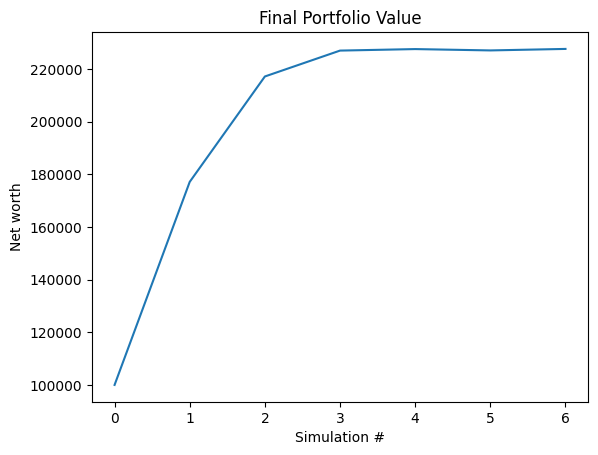

progress 0.00%
progress 16.55%
progress 33.10%
progress 49.65%
progress 66.20%
progress 82.75%
progress 99.30%
Final portfolio: $226645.513556242


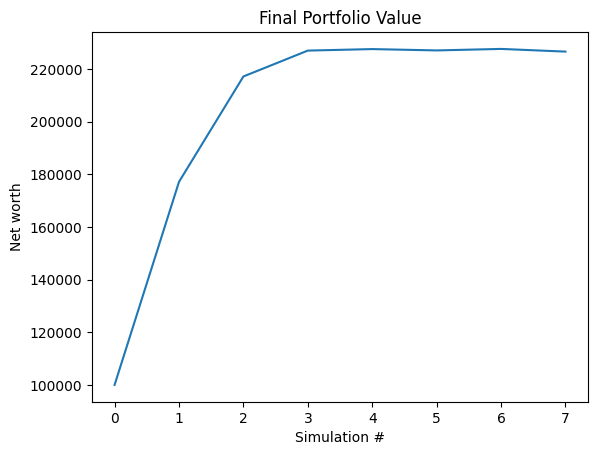

progress 0.00%
progress 16.55%
progress 33.10%
progress 49.65%
progress 66.20%
progress 82.75%
progress 99.30%
Final portfolio: $226675.52464842796


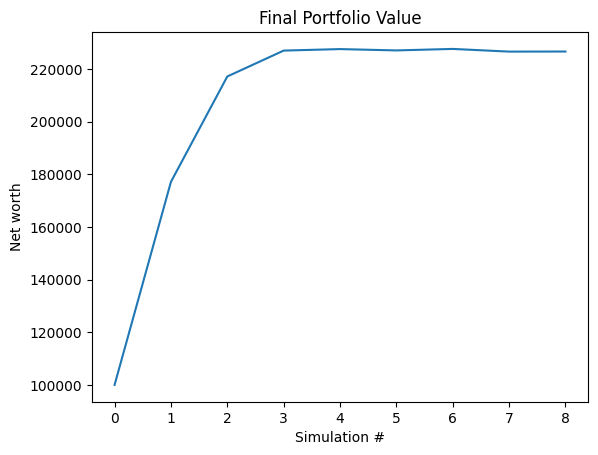

progress 0.00%
progress 16.55%
progress 33.10%
progress 49.65%
progress 66.20%
progress 82.75%
progress 99.30%
Final portfolio: $229020.8754811287


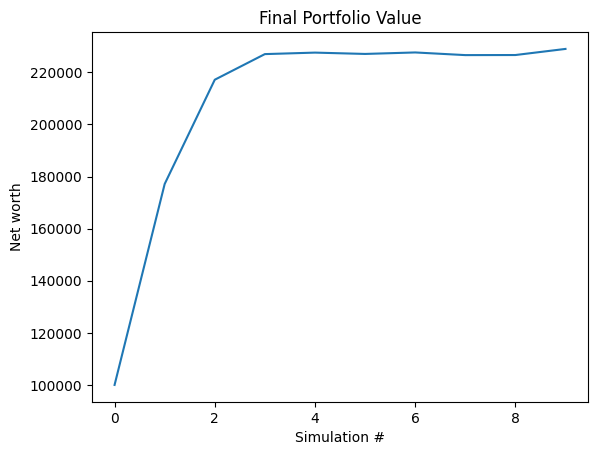

progress 0.00%
progress 16.55%
progress 33.10%
progress 49.65%
progress 66.20%
progress 82.75%
progress 99.30%
Final portfolio: $229575.15130639076


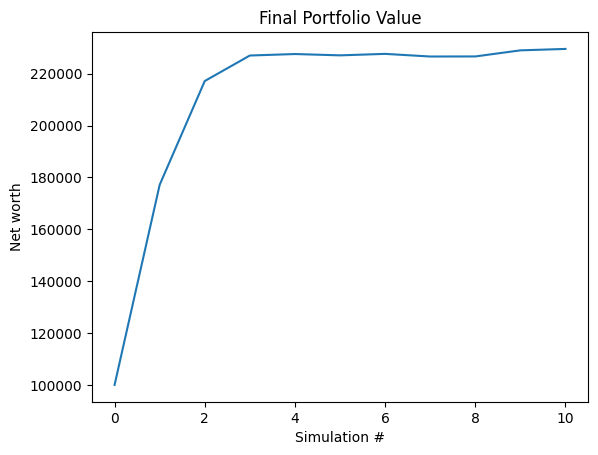

progress 0.00%
progress 16.55%
progress 33.10%
progress 49.65%
progress 66.20%
progress 82.75%
progress 99.30%
Final portfolio: $228216.0523416996


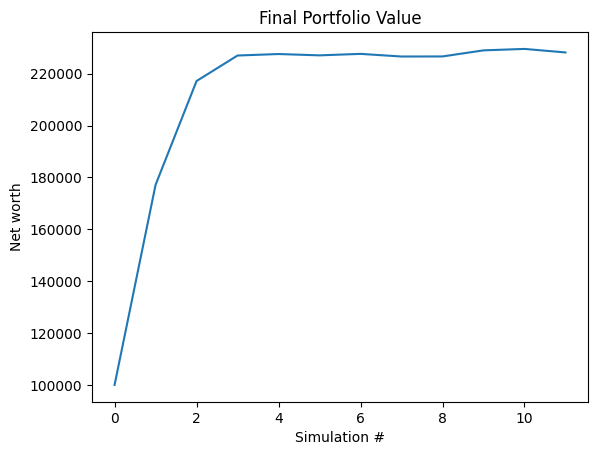

progress 0.00%
progress 16.55%
progress 33.10%
progress 49.65%
progress 66.20%
progress 82.75%
progress 99.30%
Final portfolio: $228042.54984760284


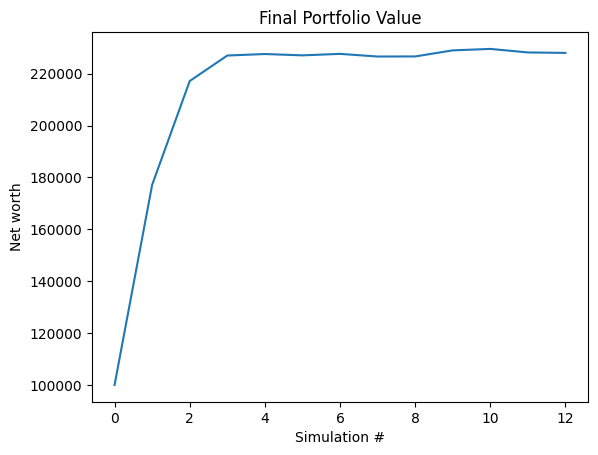

progress 0.00%
progress 16.55%
progress 33.10%
progress 49.65%
progress 66.20%
progress 82.75%
progress 99.30%
Final portfolio: $228830.23692393303


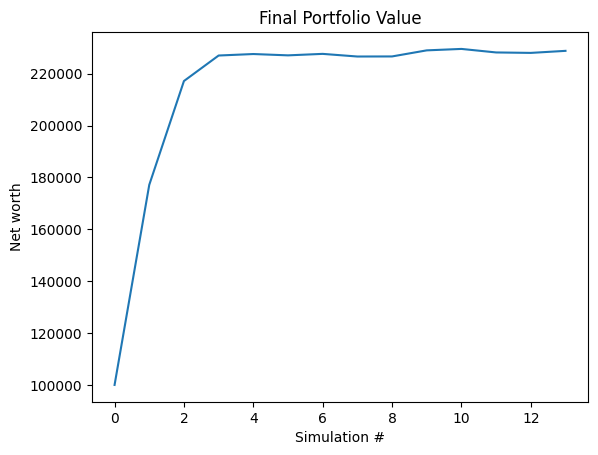

progress 0.00%
progress 16.55%
progress 33.10%
progress 49.65%
progress 66.20%
progress 82.75%
progress 99.30%
Final portfolio: $226824.30185246468


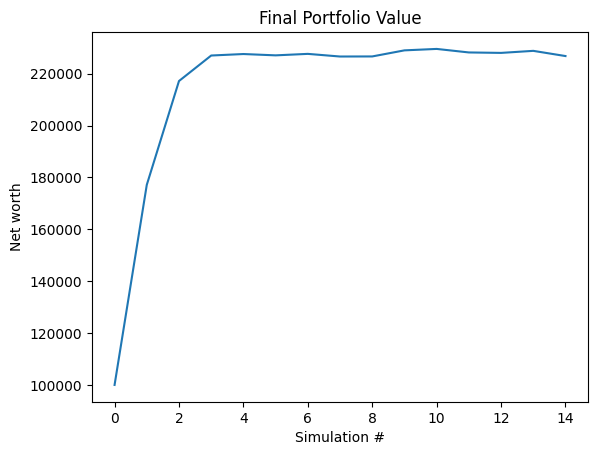

progress 0.00%
progress 16.55%
progress 33.10%
progress 49.65%
progress 66.20%
progress 82.75%
progress 99.30%
Final portfolio: $227166.37670850754


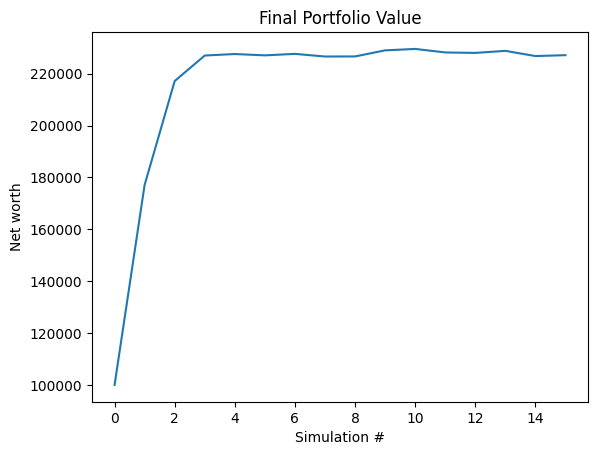

progress 0.00%
progress 16.55%
progress 33.10%
progress 49.65%
progress 66.20%
progress 82.75%
progress 99.30%
Final portfolio: $229527.20786070824


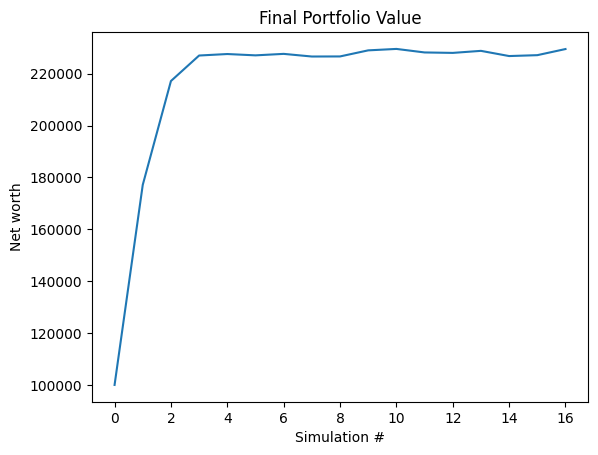

progress 0.00%
progress 16.55%
progress 33.10%
progress 49.65%
progress 66.20%
progress 82.75%
progress 99.30%
Final portfolio: $230615.96130871773


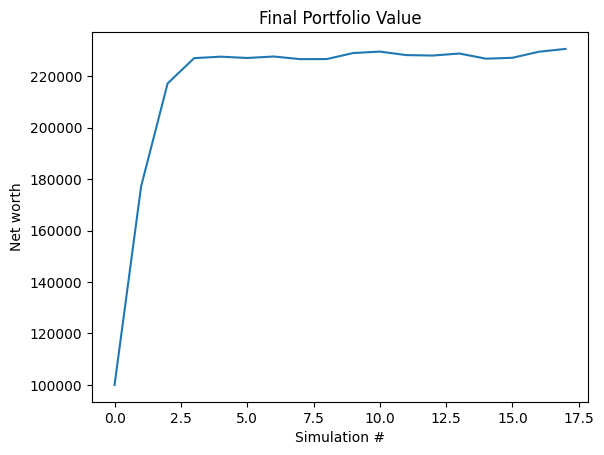

progress 0.00%
progress 16.55%
progress 33.10%
progress 49.65%
progress 66.20%
progress 82.75%
progress 99.30%
Final portfolio: $229075.25395798683


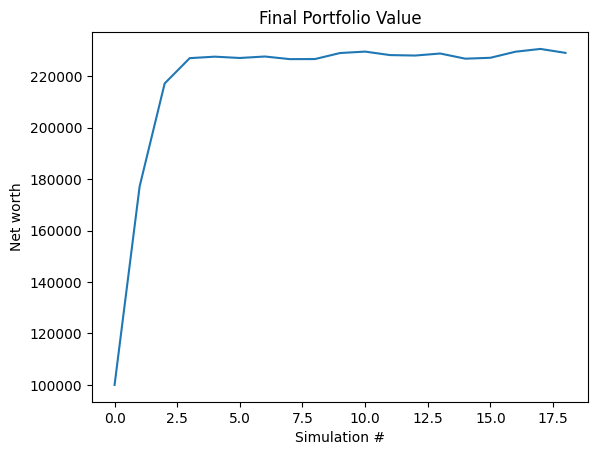

progress 0.00%
progress 16.55%
progress 33.10%
progress 49.65%
progress 66.20%
progress 82.75%
progress 99.30%
Final portfolio: $228060.20734024048


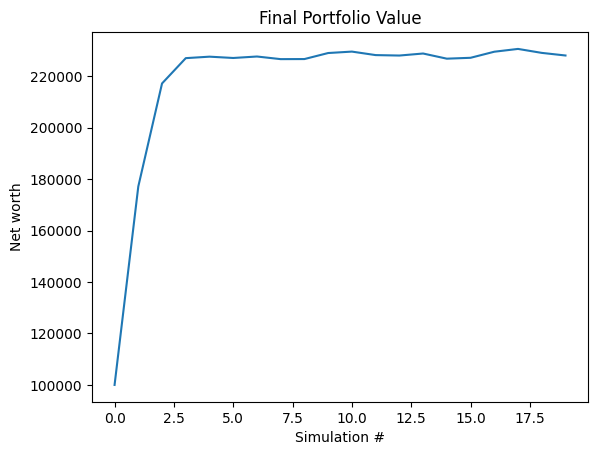

In [39]:

actions = ['Buy', 'Sell', 'Hold']
hist = 3
policy = QLearningDecisionPolicy(actions, 5) # 5 due to (budget, shares, 3-hist)
budget = 100000.0
num_stocks = 0
run_simulations(policy, budget, num_stocks, prices, hist)

In [42]:
def run_simulation_test(policy, initial_budget, initial_num_stocks, prices, hist):
    budget = initial_budget # The state is a hist + 2 dimensional vector. You’ll force it to be a NumPy matrix.
    # Calculates the portfolio value
    num_stocks = initial_num_stocks
    share_value = 0
    transitions = list()
    portfolio = []
    for i in range(len(prices) - hist - 1):
        # Initializes values that depend on computing the net worth of a portfolio
        if i % 1000 == 0:
            print('progress {:.2f}%'.format(float(100*i) / (len(prices) - hist - 1)))
        current_state = np.asmatrix(np.hstack((prices[i:i+hist], budget, num_stocks)))
        current_portfolio = budget + num_stocks * share_value
        action = policy.select_action(current_state, i)
        share_value = float(prices[i + hist])
        
        if action == 'Buy' and budget >= share_value:
            budget -= share_value
            num_stocks += 1
        elif action == 'Sell' and num_stocks > 0:
            budget += share_value
            num_stocks -= 1
        else:
            action = 'Hold'

        # Updates portfolio values based on action
        new_portfolio = budget + num_stocks * share_value
        reward = new_portfolio - current_portfolio
        next_state = np.asmatrix(np.hstack((prices[i+1:i+hist+1], budget, num_stocks)))
        transitions.append((current_state, action, reward, next_state))
        portfolio.append(new_portfolio)

        #policy.update_q(current_state, action, reward, next_state)
    
    #print(transitions)
    return portfolio

In [43]:
test_prices = get_prices('MSFT', '2017-01-22', '2019-01-22', force=True)
test_hist = 3
test_budget = 100000.0
test_num_stocks = 0
protfolio = run_simulation_test(policy, budget, test_num_stocks, test_prices, test_hist)

[*********************100%%**********************]  1 of 1 completed

progress 0.00%


441


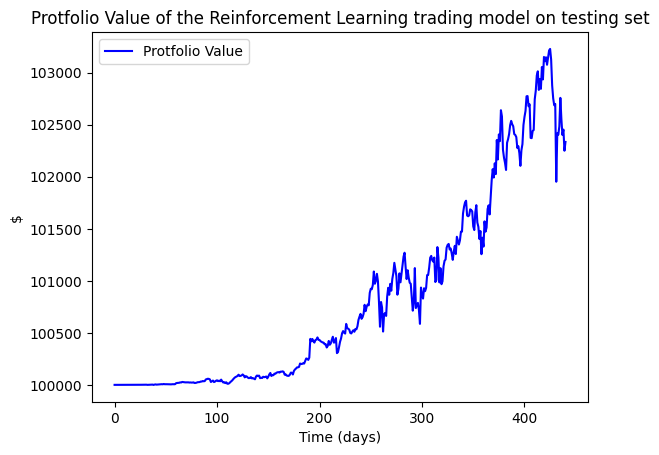

In [48]:
protfolio = protfolio[:441]
print(len(protfolio))
plt.plot(protfolio, color = 'blue', label = 'Protfolio Value')
plt.title('Protfolio Value of the Reinforcement Learning trading model on testing set')
plt.xlabel('Time (days)')
plt.ylabel ('$')
plt.legend ()

progress 0.00%
progress 16.55%
progress 33.10%
progress 49.65%
progress 66.20%
progress 82.75%
progress 99.30%
6042


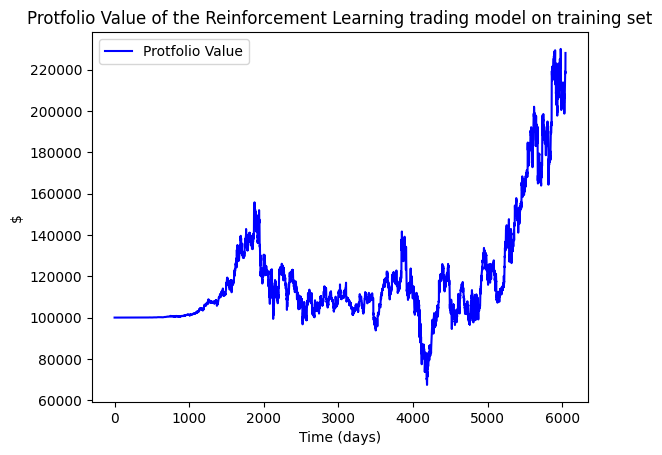

In [45]:
train_protfolio = run_simulation_test(policy, budget, test_num_stocks, prices, test_hist)
print(len(train_protfolio))
plt.plot(train_protfolio, color = 'blue', label = 'Protfolio Value')
plt.title('Protfolio Value of the Reinforcement Learning trading model on training set')
plt.xlabel('Time (days)')
plt.ylabel ('$')
plt.legend ()

In [49]:
import json

#dumping protfolio on test set as a json file
with open("RL_portfolio.json", 'w') as f:
    # indent=2 is not needed but makes the file human-readable 
    # if the data is nested
    json.dump(protfolio, f, indent=2) 